## Multi Layers for classifying images

* 이진 분류의 신경망: 출력층에 뉴런을 하나만 두었음.
  * 출력층의 활성화 값이 0.5보다 크면 양성, 그렇지 않으면 음성 클래스로 분류하는 방식
* 다중 분류의 경우는?
  * 마지막 출력층에 여러 개 뉴런을 놓는 방법?
  * 출력층에 분류할 클래스 개수만큼 뉴런을 배치함!
* 다중 분류의 문제점
  * 활성화 출력의 합이 1이 되지 않으면 비교하기 어려움
  * 소프트맥스 함수를 적용하여 출력 강도를 정규화
* 다중 분류에서 사용하는 손실 함수: 크로스 엔트로피(cross entropy)
  * 이진 분류에서는 로지스틱 손실 함수를 사용함

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class MultiClassNetwork:
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        # 은닉층의 뉴런 갯수
        self.units = units
        # 배치 크기
        self.batch_size = batch_size
        # 은닉층의 가중치
        self.w1 = None
        # 은닉층의 절편
        self.b1 = None
        # 출력층의 가중치
        self.w2 = None
        # 출력층의 절편
        self.b2 = None
        # 은닉층의 활성화 출력
        self.a1 = None
        # 훈련 손실
        self.losses = []
        # 검증 손실
        self.val_losses = []
        # 학습률
        self.lr = learning_rate
        # L1 손실 하이퍼파라미터
        self.l1 = l1
        # L2 손실 하이퍼파라미트
        self.l2 = l2
    
    def forpass(self, x):
        # 첫 번째 층의 선형 식 계산
        z1 = np.dot(x, self.w1) + self.b1
        # 활성화 함수 적용
        self.a1 = self.sigmoid(z1)
        # 두 번째 층의 선형 식 계산
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        # 샘플 개수
        m = len(x)
        # 출력층의 가중치와 절편에 대한 gradient 계산
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 gradient 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 인닉층의 가중치와 절편에 대한 gradient 계산
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        # 안전한 계산을 위한 클리핑
        z = np.clip(z, -100, None)
        # 시그모이드 계산
        a = 1 / (1 + np.exp(-z))
        return a
    
    def softmax(self, z):
        # 안전한 계산을 위한 클리핑
        z = np.clip(z, -100, None)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
    
    def init_weights(self, n_features, n_classes):
        # (특성 개수, 은닉층의 크기)
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        # 은닉층의 크기
        self.b1 = np.zeros(self.units)
        # (은닉층의 크기, 클래스 개수)
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        # 은닉층과 출력층의 가중치 초기화
        self.init_weights(x.shape[1], y.shape[1])
        
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치 순환
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1 - 1e-10)
                loss += np.sum(-y_batch * np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)
    
    # 미니배치 generator 함수
    def gen_batch(self, x, y):
        length = len(x)
        # 미니배치 횟수
        bins = length // self.batch_size
        if length % self.batch_size:
            # 나누어 떨어지지 않는 경우
            bins += 1
        # 인덱스 섞기
        idxes = np.random.permutation(np.arange(len(x)))
        x = x[idxes]
        y = y[idxes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            # batch_size 만큼 슬라이싱하여 반환
            yield x[start:end], y[start:end]
        
    def training(self, x, y):
        # 샘플 개수
        m = len(x)
        # 정방향 계산
        z = self.forpass(x)
        # 활성화 함수
        a = self.softmax(z)
        # 오차 계산
        err = -(y - a)
        # 오차 역전파로 gradient 계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # gradient 에서 페널티 항의 미분값을 뺌
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def predict(self, x):
        # 정방향 계산
        z = self.forpass(x)
        # 가장 큰 값의 인덱스 반환
        return np.argmax(z, axis=1)
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True 비율 반환
        return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
                self.l2 / 2 * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2))
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1 - 1e-10)
        val_loss = np.sum(-y_val * np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [3]:
tf.__version__

'2.3.0'

In [4]:
# loading fasion MNIST dataset
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
# x_train_all: 3차원
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


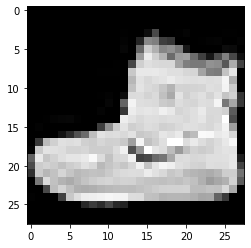

In [6]:
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [7]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [8]:
class_names = [
    '티셔츠/윗도리', '바지', '스웨터', '드레스', '코트',
    '샌들', '셔츠', '스니커즈', '가방', '앵클부츠'
]

print(class_names[y_train_all[0]])

앵클부츠


In [9]:
# 타깃 분포 확인
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

In [10]:
# 훈련 세트 / 검증 세트 분리
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42
)

print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [11]:
# 입력 데이터 정규화
x_train = x_train / 255
x_val = x_val / 255

# 훈련 세트와 검증 세트의 차원 변경
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [12]:
# 원-핫 인코딩 예제
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [13]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [14]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

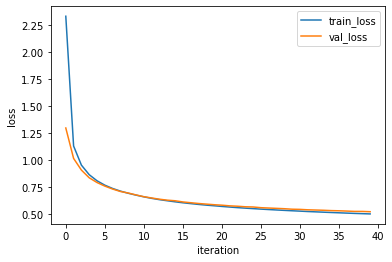

In [15]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [16]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [17]:
np.random.permutation(np.arange(12000) % 10)

array([4, 6, 3, ..., 0, 6, 6], dtype=int32)

In [18]:
np.sum(y_val == np.random.permutation(np.arange(12000) % 10)) / 12000

0.10325

## Tensorflow, Keras 를 이용하여 신경망 만들기

In [19]:
# 텐서플로와 케라스 이용한 신경망 V1.
"""
# 훈련할 가중치 변수 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 optimizer 선언
optimizer = tf.optimizers.SGD(lr=0.01)

# epochs 수만큼 훈련
epochs = 10
for step in range(epochs):
    # 자동 미분을 위하여 연산 과정 기록
    with tf.GradientTape() as tape:
        z_net = w * x_train + b
        z_net = tf.reshape(z_net, [-1])
        sqr_errors = tf.square(y_train - z_net) 
        mean_cost = tf.reduce_mean(sqr_errors)
    
    # 손실 함수에 대한 가중치의 gradient 계산
    grads = tape.gradient(mean_cost, [w, b])
    
    # optimizer에 gradient 반영
    optimizer.apply_gradients(zip(grads, [w, b]))
"""

'\n# 훈련할 가중치 변수 선언\nw = tf.Variable(tf.zeros(shape=(1)))\nb = tf.Variable(tf.zeros(shape=(1)))\n\n# 경사 하강법 optimizer 선언\noptimizer = tf.optimizers.SGD(lr=0.01)\n\n# epochs 수만큼 훈련\nepochs = 10\nfor step in range(epochs):\n    # 자동 미분을 위하여 연산 과정 기록\n    with tf.GradientTape() as tape:\n        z_net = w * x_train + b\n        z_net = tf.reshape(z_net, [-1])\n        sqr_errors = tf.square(y_train - z_net) \n        mean_cost = tf.reduce_mean(sqr_errors)\n    \n    # 손실 함수에 대한 가중치의 gradient 계산\n    grads = tape.gradient(mean_cost, [w, b])\n    \n    # optimizer에 gradient 반영\n    optimizer.apply_gradients(zip(grads, [w, b]))\n'

In [20]:
# 신경망 모델
model = tf.keras.models.Sequential([
    # unit: 은닉층의 뉴런 개수 / activation: 활성화 함수 지정
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 1s 368us/step - loss: 5.3644e-07
Epoch 2/10
1500/1500 [==============================] - 1s 354us/step - loss: 5.3644e-07
Epoch 3/10
1500/1500 [==============================] - 1s 351us/step - loss: 5.3644e-07
Epoch 4/10
1500/1500 [==============================] - 1s 354us/step - loss: 5.3644e-07
Epoch 5/10
1500/1500 [==============================] - 1s 353us/step - loss: 5.3644e-07
Epoch 6/10
1500/1500 [==============================] - 1s 362us/step - loss: 5.3644e-07
Epoch 7/10
1500/1500 [==============================] - 1s 357us/step - loss: 5.3644e-07
Epoch 8/10
1500/1500 [==============================] - 1s 351us/step - loss: 5.3644e-07
Epoch 9/10
1500/1500 [==============================] - 1s 357us/step - loss: 5.3644e-07
Epoch 10/10
1500/1500 [==============================] - 1s 357us/step - loss: 5.3644e-07


### Keras 를 이용한 다중 분류 신경망 만들기

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(100, activation='sigmoid', input_shape=(784,)),
    Dense(10, activation='softmax')
])
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 1s 742us/step - loss: 1.3853 - accuracy: 0.6551 - val_loss: 0.9552 - val_accuracy: 0.7312
Epoch 2/40
1500/1500 [==============================] - 1s 648us/step - loss: 0.8339 - accuracy: 0.7461 - val_loss: 0.7443 - val_accuracy: 0.7628
Epoch 3/40
1500/1500 [==============================] - 1s 648us/step - loss: 0.7045 - accuracy: 0.7676 - val_loss: 0.6590 - val_accuracy: 0.7820
Epoch 4/40
1500/1500 [==============================] - 1s 657us/step - loss: 0.6411 - accuracy: 0.7832 - val_loss: 0.6097 - val_accuracy: 0.7943
Epoch 5/40
1500/1500 [==============================] - 1s 651us/step - loss: 0.6007 - accuracy: 0.7956 - val_loss: 0.5743 - val_accuracy: 0.8046
Epoch 6/40
1500/1500 [==============================] - 1s 655us/step - loss: 0.5716 - accuracy: 0.8042 - val_loss: 0.5504 - val_accuracy: 0.8108
Epoch 7/40
1500/1500 [==============================] - 1s 659us/step - loss: 0.5495 - accuracy: 0.8113 - val_loss: 0.5293 -

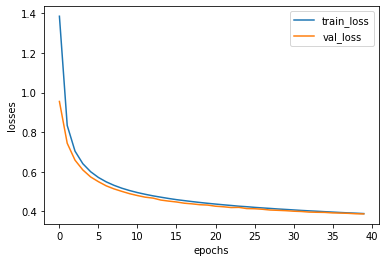

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('losses')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

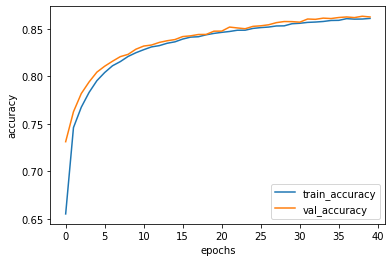

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [24]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8627499938011169
